In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Paths to dataset
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Paths to datasets
DATA_DIR = "/content/drive/MyDrive/VGG19/DATA"
CATEGORIES = ["Healthy", "Sick"]

In [4]:
# Parameters
IMG_SIZE = 224  # ResNet50 input size
BATCH_SIZE = 32
EPOCHS = 10

# Preprocessing Function
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Thresholding to segment the ROI
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Extract largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi = image[y:y+h, x:x+w]
    # Resize ROI to match ResNet50 input size
    roi_resized = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
    return roi_resized

In [5]:
# Load and preprocess dataset
def load_dataset():
    data = []
    labels = []
    for category in CATEGORIES:
        folder_path = os.path.join(DATA_DIR, category)
        label = category
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                roi_resized = preprocess_image(img_path)
                data.append(roi_resized)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data), np.array(labels)

In [6]:
# Load dataset
X, y = load_dataset()

# Normalize and preprocess data
X = X / 255.0  # Normalize pixel values
X = np.expand_dims(X, axis=-1)  # Add channel dimension
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to 3-channel
X = preprocess_input(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(CATEGORIES))


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [8]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(CATEGORIES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.5362 - loss: 0.8275 - val_accuracy: 0.6050 - val_loss: 0.7022
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 220s 8s/step - accuracy: 0.5302 - loss: 0.7269 - val_accuracy: 0.6100 - val_loss: 0.6821
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.6116 - loss: 0.6516 - val_accuracy: 0.5650 - val_loss: 0.6592
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - accuracy: 0.7125 - loss: 0.6083 - val_accuracy: 0.6850 - val_loss: 0.6239
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.7035 - loss: 0.6003 - val_accuracy: 0.7000 - val_loss: 0.6150
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.7066 - loss: 0.5950 - val_accuracy: 0.5950 - val_loss: 0.6341
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.6908 - loss: 0.6027 - val_accuracy: 0.6800 - val_loss: 0.6098
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.7311 - loss: 0.5834 - val_accuracy: 0.6800 - 

NameError: name 'history' is not defined

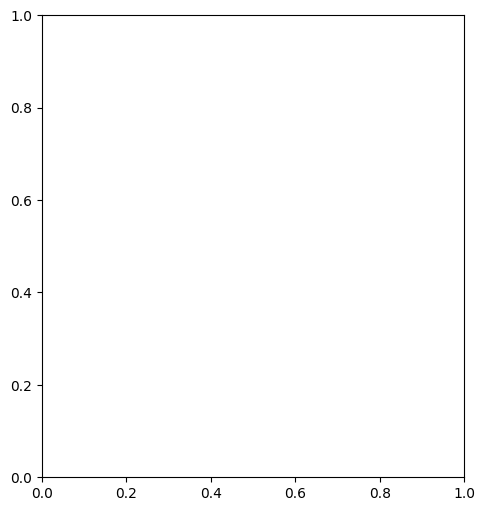

In [10]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()
